In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pyodbc
import warnings

from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

In [80]:
cnxn_str = ("Driver={ODBC Driver 17 for SQL Server};"
            "Server=DESKTOP-5SGGQQV;"
            "Database=AnalisisEconomicoBO;"
            "Trusted_Connection=yes;")
cnxn = pyodbc.connect(cnxn_str)

In [81]:
df_dataMart = pd.read_sql_query("SELECT * FROM bolivia_model_dataset;", cnxn)
df_dataMart["fecha"] = pd.to_datetime(df_dataMart["fecha"])
df_dataMart = df_dataMart.set_index("fecha")
df_dataMart.head()

,exportaciones,importaciones,precio_petroleo,igae,pib
fecha,,,,,
2008-01-01,1.107997e+09,7.219843e+09,681.69,177.11,6837877.84
2008-04-01,1.225005e+09,8.736367e+09,862.01,206.05,7955173.49
2008-07-01,1.340753e+09,9.730266e+09,821.17,198.87,7678219.30
2008-10-01,1.238619e+09,9.810689e+09,406.80,202.19,7806555.65
2009-01-01,8.211907e+08,7.502351e+09,297.91,182.33,7039509.99


In [82]:
print(df_dataMart.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68 entries, 2008-01-01 to 2024-10-01
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   exportaciones    68 non-null     float64
 1   importaciones    68 non-null     float64
 2   precio_petroleo  68 non-null     float64
 3   igae             68 non-null     float64
 4   pib              68 non-null     float64
dtypes: float64(5)
memory usage: 3.2 KB
None


**Analisis preliminar**

In [83]:
df_dataMart.describe()

,exportaciones,importaciones,precio_petroleo,igae,pib
count,6.800000e+01,6.800000e+01,68.000000,68.000000,6.800000e+01
mean,1.648450e+09,1.526624e+10,507.975882,273.673824,1.056615e+07
std,4.456698e+08,3.920901e+09,153.173356,48.622884,1.877232e+06
min,7.938004e+08,6.964549e+09,193.440000,177.110000,6.837878e+06
25%,1.330861e+09,1.356507e+10,390.957500,233.385000,9.010629e+06
50%,1.579050e+09,1.596260e+10,518.400000,282.630000,1.091185e+07
75%,2.011120e+09,1.730985e+10,643.727500,315.605000,1.218484e+07
max,2.760536e+09,2.347155e+10,862.010000,362.320000,1.398874e+07


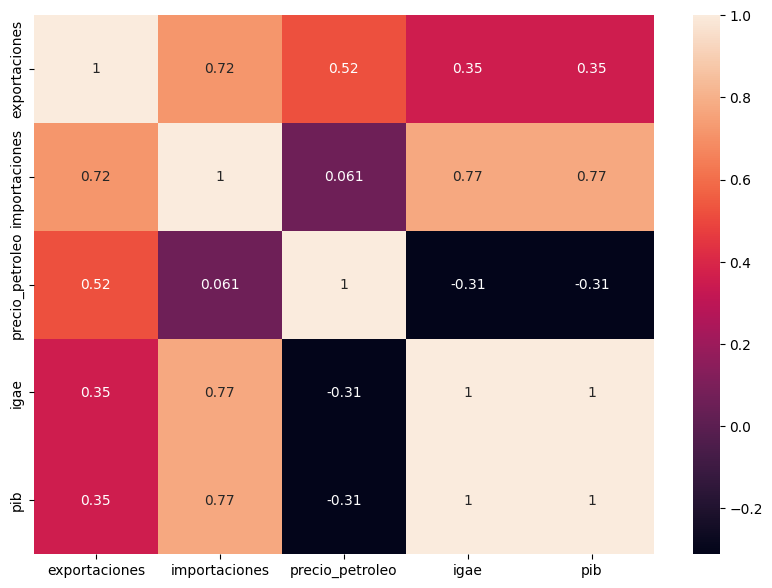

In [84]:
corr_df = df_dataMart.corr(method='pearson')

plt.figure(figsize=(10, 7))
sns.heatmap(corr_df, annot=True)
plt.show()

In [ ]:
from dataprep.eda import create_report
create_report(df_dataMart).show()

**Estacionariedad**

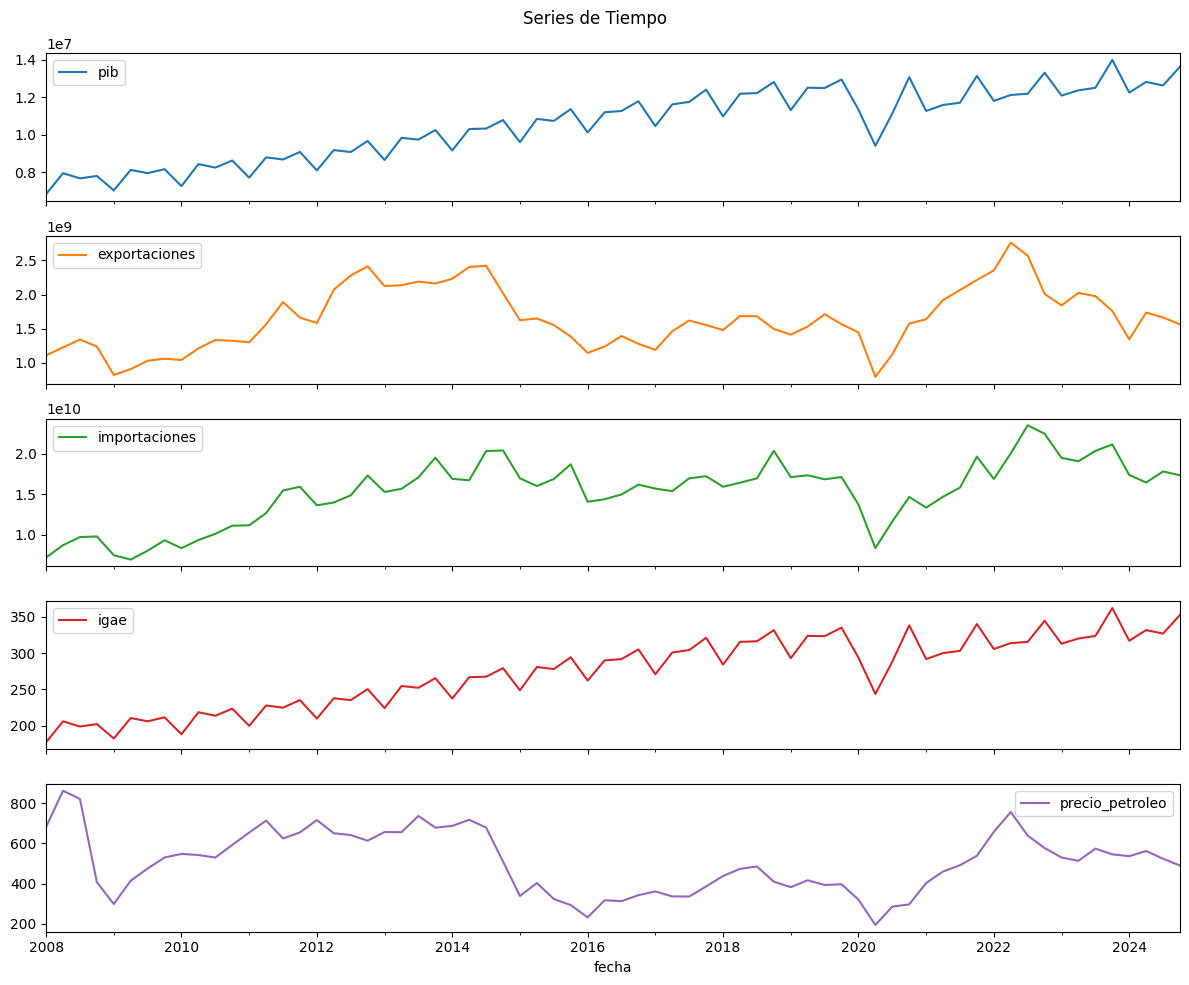

In [85]:
# Graficar las series
# ===========================================
variables = ["pib", "exportaciones", "importaciones", "igae", "precio_petroleo"]

df_dataMart[variables].plot(subplots=True, figsize=(12, 10), title="Series de Tiempo")
plt.tight_layout()
plt.show()

In [86]:
def test_adf(series):
    result = adfuller(series, autolag="AIC")
    return result[0], result[1]  # estadístico, p-valor

In [87]:
def test_pp(series):
    pp = PhillipsPerron(series)
    return pp.stat, pp.pvalue

In [88]:
def test_kpss(series, regression="c"):  # "c" = constante, "ct" = constante + tendencia
    result = kpss(series, regression=regression, nlags="auto")
    return result[0], result[1]  # estadístico, p-valor

In [89]:
def interpretar(adf_p, pp_p, kpss_p, alpha=0.05):
    estacionaria_adf = adf_p < alpha
    estacionaria_pp = pp_p < alpha
    estacionaria_kpss = kpss_p >= alpha  # KPSS al revés

    if estacionaria_adf and estacionaria_pp and estacionaria_kpss:
        return "Estacionaria"
    else:
        return "No estacionaria"

In [90]:
# ===========================================
# Crear tabla resumen
# ===========================================
def tablaResumen(data):
    resultados = []

    for var in variables:
        serie = data[var].dropna()
        adf_stat, adf_p = test_adf(serie)
        pp_stat, pp_p = test_pp(serie)
        kpss_stat, kpss_p = test_kpss(serie, regression="c")
        
        interpretacion = interpretar(adf_p, pp_p, kpss_p)
        
        resultados.append({
            "Variable": var,
            "ADF Estadístico": adf_stat,
            "ADF p-valor": adf_p,
            "PP Estadístico": pp_stat,
            "PP p-valor": pp_p,
            "KPSS Estadístico": kpss_stat,
            "KPSS p-valor": kpss_p,
            "Interpretación": interpretacion
        })

    tabla_resultados = pd.DataFrame(resultados)
    print("\n===== Tabla Resumen de Tests de Raíz Unitaria =====\n")
    print(tabla_resultados)

In [91]:
tablaResumen(df_dataMart)


===== Tabla Resumen de Tests de Raíz Unitaria =====

          Variable  ADF Estadístico  ADF p-valor  PP Estadístico  PP p-valor  \
0              pib        -1.509013     0.529048       -2.074963    0.254701   
1    exportaciones        -3.100681     0.026503       -2.324337    0.164239   
2    importaciones        -2.626058     0.087730       -2.463586    0.124587   
3             igae        -1.508928     0.529090       -2.074815    0.254761   
4  precio_petroleo        -3.656316     0.004771       -2.444450    0.129582   

   KPSS Estadístico  KPSS p-valor   Interpretación  
0          1.182107          0.01  No estacionaria  
1          0.236696          0.10  No estacionaria  
2          0.785202          0.01  No estacionaria  
3          1.182108          0.01  No estacionaria  
4          0.335364          0.10  No estacionaria  


Graficamos la no estacionariedad

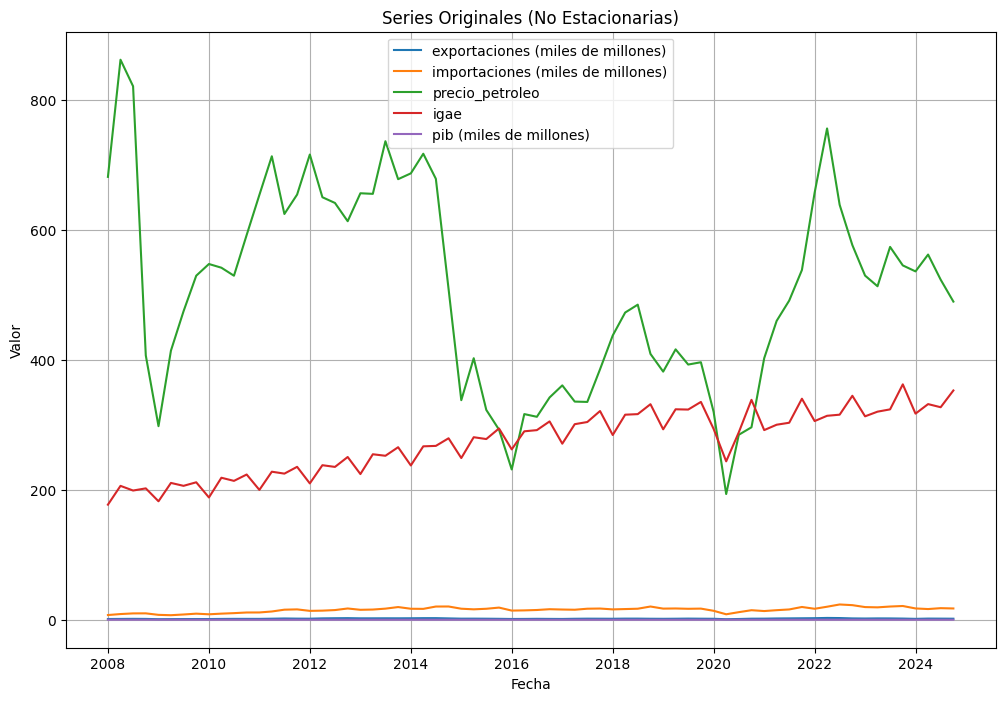

In [92]:
# Lista de variables que quieres dividir entre 1e9
escalar = ["pib","exportaciones", "importaciones"]

plt.figure(figsize=(12, 8))

for col in df_dataMart.select_dtypes(include=["int64", "float64"]).columns:
    if col in escalar:
        plt.plot(df_dataMart.index, df_dataMart[col] / 1e9, label=f"{col} (miles de millones)")
    else:
        plt.plot(df_dataMart.index, df_dataMart[col], label=col)

plt.title("Series Originales (No Estacionarias)")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()

Conversion a estacionariedad de primer orden


DataFrame Diferenciado (Estacionario de primer orden):
            exportaciones  importaciones  precio_petroleo   igae         pib
fecha                                                                       
2008-04-01   1.170083e+08   1.516523e+09           180.32  28.94  1117295.65
2008-07-01   1.157481e+08   9.938995e+08           -40.84  -7.18  -276954.19
2008-10-01  -1.021335e+08   8.042246e+07          -414.37   3.32   128336.35
2009-01-01  -4.174287e+08  -2.308338e+09          -108.89 -19.86  -767045.66
2009-04-01   8.620837e+07  -5.378020e+08           116.33  28.25  1090656.64


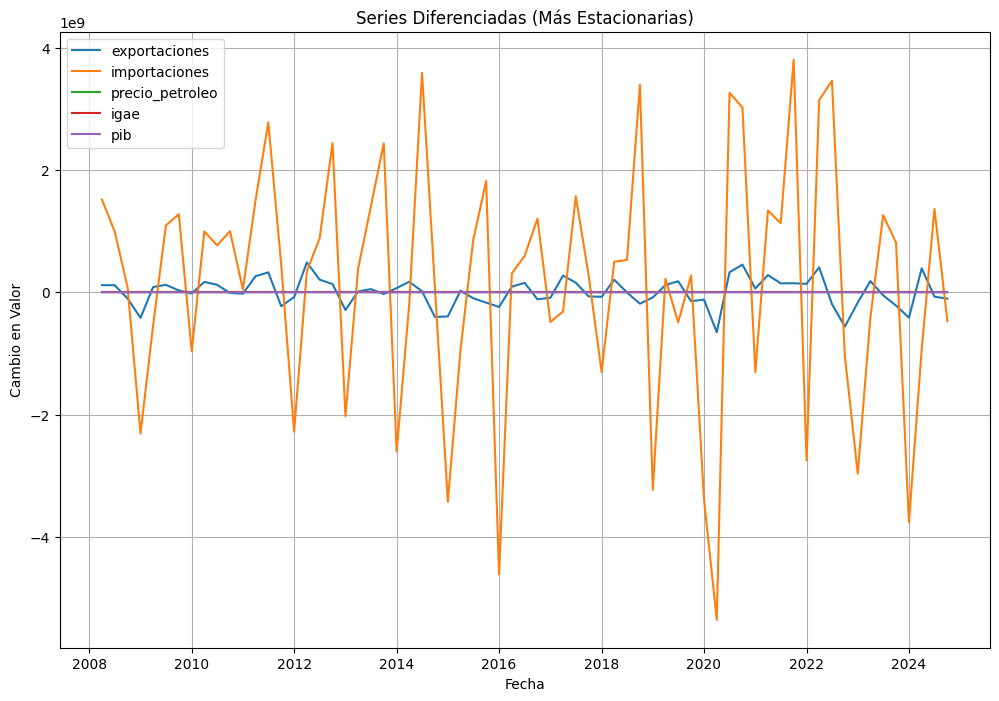

In [93]:
# Crear un nuevo DataFrame para las series diferenciadas
# diferenciacion de primer orden
df_diff =df_dataMart.diff().dropna()

print("\nDataFrame Diferenciado (Estacionario de primer orden):")
print(df_diff.head())

# Graficar las series diferenciadas
plt.figure(figsize=(12, 8))
for col in df_diff.columns:
    plt.plot(df_diff.index, df_diff[col], label=col)
plt.title("Series Diferenciadas (Más Estacionarias)")
plt.xlabel("Fecha")
plt.ylabel("Cambio en Valor")
plt.legend()
plt.grid(True)
plt.show()

In [94]:
tablaResumen(df_diff)


===== Tabla Resumen de Tests de Raíz Unitaria =====

          Variable  ADF Estadístico   ADF p-valor  PP Estadístico  \
0              pib        -2.924311  4.259309e-02      -30.349386   
1    exportaciones        -7.254109  1.748990e-10       -6.849355   
2    importaciones        -2.411688  1.384648e-01       -9.830145   
3             igae        -2.923951  4.263289e-02      -30.348808   
4  precio_petroleo        -6.884854  1.403069e-09       -6.887261   

     PP p-valor  KPSS Estadístico  KPSS p-valor   Interpretación  
0  0.000000e+00          0.088317           0.1     Estacionaria  
1  1.710008e-09          0.080244           0.1     Estacionaria  
2  5.062743e-17          0.242057           0.1  No estacionaria  
3  0.000000e+00          0.088305           0.1     Estacionaria  
4  1.384354e-09          0.060898           0.1     Estacionaria  


Conversion a estacionariedad de 2do orden


DataFrame Diferenciado (Estacionario de segundo orden):
            exportaciones  importaciones  precio_petroleo   igae         pib
fecha                                                                       
2008-04-01   1.170083e+08   1.516523e+09           180.32  28.94  1117295.65
2008-07-01   1.157481e+08   9.938995e+08           -40.84  -7.18  -276954.19
2008-10-01  -1.021335e+08   8.042246e+07          -414.37   3.32   128336.35
2009-01-01  -4.174287e+08  -2.308338e+09          -108.89 -19.86  -767045.66
2009-04-01   8.620837e+07  -5.378020e+08           116.33  28.25  1090656.64


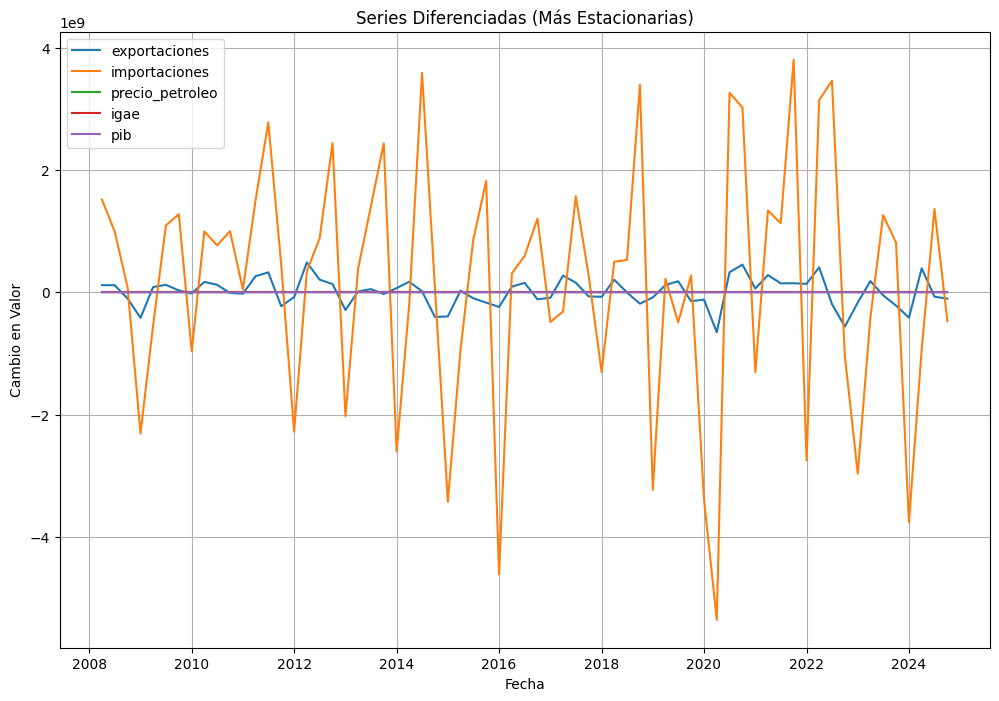

In [95]:
# Hacer una copia del DataFrame ya diferenciado en 1
df_diff2 = df_diff.copy()

# Diferenciacion de segundo orden solo para importaciones
df_diff2["importaciones"] = df_diff2["importaciones"].diff().dropna()
df_diff2 = df_diff2.dropna()
print("\nDataFrame Diferenciado (Estacionario de segundo orden):")
print(df_diff.head())

# Graficar las series diferenciadas
plt.figure(figsize=(12, 8))
for col in df_diff.columns:
    plt.plot(df_diff.index, df_diff[col], label=col)
plt.title("Series Diferenciadas (Más Estacionarias)")
plt.xlabel("Fecha")
plt.ylabel("Cambio en Valor")
plt.legend()
plt.grid(True)
plt.show()

In [96]:
tablaResumen(df_diff2)


===== Tabla Resumen de Tests de Raíz Unitaria =====

          Variable  ADF Estadístico   ADF p-valor  PP Estadístico  \
0              pib        -2.884941  4.712738e-02      -29.488645   
1    exportaciones        -7.152320  3.118013e-10       -6.814040   
2    importaciones        -4.470246  2.224696e-04      -33.761522   
3             igae        -2.884566  4.717242e-02      -29.488300   
4  precio_petroleo        -6.389704  2.120834e-08       -6.245338   

     PP p-valor  KPSS Estadístico  KPSS p-valor Interpretación  
0  0.000000e+00          0.069879           0.1   Estacionaria  
1  2.081023e-09          0.071974           0.1   Estacionaria  
2  0.000000e+00          0.201051           0.1   Estacionaria  
3  0.000000e+00          0.069884           0.1   Estacionaria  
4  4.590570e-08          0.125981           0.1   Estacionaria  


 Normalización (Estandarización Z-score)


DataFrame Diferenciado y Normalizado (Z-score):
            exportaciones  importaciones  precio_petroleo      igae       pib
fecha                                                                        
2008-07-01       0.479404      -0.166921        -0.428911 -0.377520 -0.377253
2008-10-01      -0.464530      -0.299388        -4.980502  0.043954  0.044118
2009-01-01      -1.830490      -0.799384        -1.258124 -0.886499 -0.886790
2009-04-01       0.351428       0.610267         1.486259  1.044652  1.044620
2009-07-01       0.507688       0.562842         0.805708 -0.269542 -0.269595


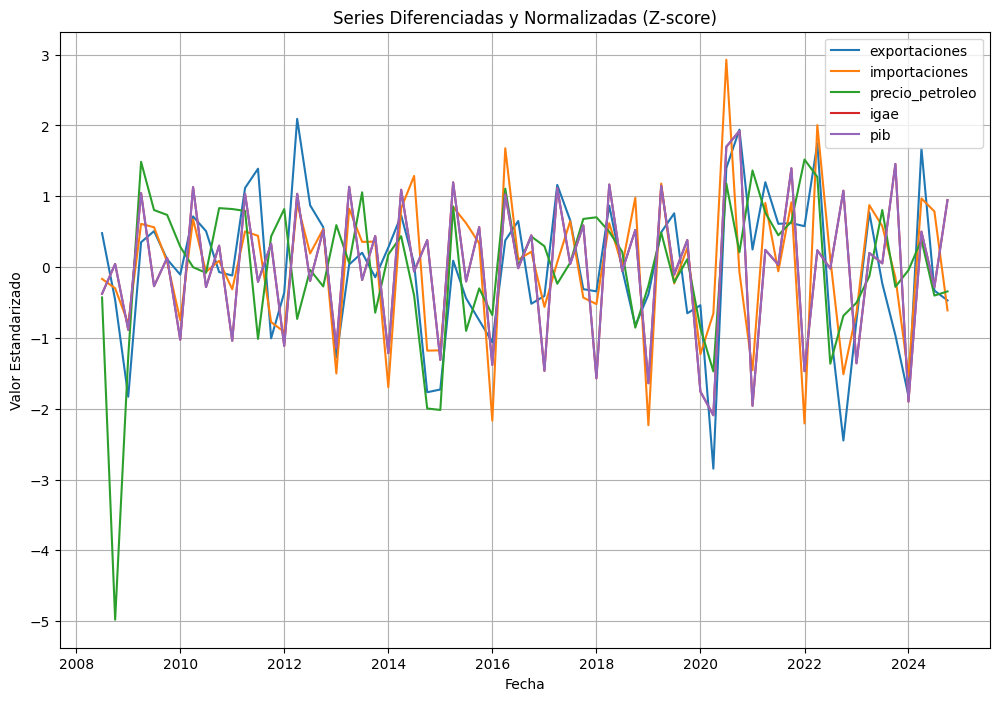

In [97]:
# Las series diferenciadas son las que vamos a normalizar
# Guardamos los índices para reconstruir el DataFrame después de la normalización
indices_diff = df_diff2.index
column_names_diff = df_diff2.columns

# Inicializar el StandardScaler
scaler = StandardScaler()

# Ajustar el scaler y transformar los datos
df_scaled_array = scaler.fit_transform(df_diff2)

# Convertir el array normalizado de nuevo a un DataFrame de pandas
df_normalized = pd.DataFrame(df_scaled_array, index=indices_diff, columns=column_names_diff)

print("\nDataFrame Diferenciado y Normalizado (Z-score):")
print(df_normalized.head())

# Graficar las series diferenciadas y normalizadas
plt.figure(figsize=(12, 8))
for col in df_normalized.columns:
    plt.plot(df_normalized.index, df_normalized[col], label=col)
plt.title("Series Diferenciadas y Normalizadas (Z-score)")
plt.xlabel("Fecha")
plt.ylabel("Valor Estandarizado")
plt.legend()
plt.grid(True)
plt.show()